# Test

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from learn import *
sys.path.insert(0, 'code')
from v17 import *
from v17 import _internal_validate_predict_best_param
from v17 import evalfscore

In [26]:
sz = 256
num_slice = 25

num_gpus = 4
gpu_start = 4
num_workers = 0
device_ids = range(gpu_start, gpu_start + num_gpus)
# device_ids = [0,1,4,5]
torch.cuda.set_device(gpu_start)
bs = 8

model_name = 'deeplab'
datapaths = ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']
datapath = datapaths[1]

## Preprocessing

In [4]:
# !python code/v5_im-full_rgb.py preproc_test {datapaths[0]}

In [5]:
# !python code/v5_im-full_rgb.py preproc_test {datapaths[3]}

In [6]:
# !python code/v5_im-full_rgb.py preproc_test {datapaths[1]}
# !python code/v5_im-full_rgb.py preproc_test {datapaths[2]}

# Copy py content to solve memory error

In [2]:
### prediction args
class args:
    datapath_idx = 1
    
    pred = True
    rescale = True
    eval = True
    debug = False
    
    learn = False
    
    num_gpus = 2
    gpu_start = 2
    bs = 4
    num_slice = 81

In [3]:
# import argparse
# helpstr = """ Accepts an datapath index. Cities are arranged in the order of:
# 'data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 
#              'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train'

# """
# parser = argparse.ArgumentParser(description=helpstr)
# parser.add_argument('datapath_idx', type=int, help='the datapath index')
# parser.add_argument('--num_gpus', type=int, help='number of GPU cores', default=1)
# parser.add_argument('--gpu_start', type=int, help='first GPU index', default=0)
# parser.add_argument('--bs', type=int, help='batch size', default=8)
# parser.add_argument('--num_slice', type=int, help='number of slices to cut per image', default=9)

# # train
# parser.add_argument('--learn', help='learning trigger', action='store_true', default=False)
# parser.add_argument('--rescale', help='rescaling trigger', action='store_true', default=False)
# parser.add_argument('--lr', type=float, help='set lr')
# parser.add_argument('--use_wd_sched', help='training trigger', action='store_true', default=False)
# parser.add_argument('--wd', type=float, help='set wd')
# parser.add_argument('--n_cycles', type=int, help='number of epochs')


# # predict
# parser.add_argument('--pred', help='prediction trigger', action='store_true', default=False)
# parser.add_argument('--eval', help='evaluation trigger', action='store_true', default=False)
# parser.add_argument('--test', help='test trigger', action='store_true', default=False)
# parser.add_argument('--debug', help='load only first 50 images', action='store_true', default=False)
# args = parser.parse_args()
# if args.eval: args.pred = True
# Args parsing end

from learn import *
sys.path.insert(0, 'code')
from v17 import *
from v17 import _internal_validate_predict_best_param

sz = 256
num_slice = args.num_slice

num_gpus = args.num_gpus
gpu_start = args.gpu_start
num_workers = 0
device_ids = range(gpu_start, gpu_start + num_gpus)
# device_ids = [0,1,4,5]
torch.cuda.set_device(gpu_start)
bs = args.bs

model_name = 'deeplab'
datapaths = ['data/train/AOI_2_Vegas_Train', 'data/train/AOI_3_Paris_Train', 
             'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']
model_name = 'deeplab'
load_paths = [model_name + '-' + o for o in ['vegas', 'paris', 'shanghai', '5']]
datapath = datapaths[args.datapath_idx]
base_load_path = load_paths[args.datapath_idx]
base_save_path = 'debug' if args.debug else base_load_path

scale_load_path = base_load_path + '-scale'
scale_save_path = base_save_path + '-scale'

data = None
### train
if args.learn:
    is_eval, is_pred = False, False
    learn, denorm, data = learner_on_dataset(datapath, bs, device_ids, num_workers, model_name=model_name,
                                             debug=args.debug, data=data, num_slice=num_slice, sz=sz,
                                             is_eval=is_eval, is_pred=is_pred, rescale=args.rescale)
    if args.rescale:
        learn_load_path = scale_load_path
        learn_save_path = scale_save_path
    else:
        learn_load_path = base_load_path
        learn_save_path = base_save_path
    learn.load(learn_load_path)
    learn.unfreeze()

    lr = args.lr
    wd = args.wd
    use_wd_sched = args.use_wd_sched
    n_cycles = args.n_cycles

    train_and_plot(learn, 0, learn_save_path, lrs = lr, n_cycles=n_cycles, wds=wd, use_wd_sched=use_wd_sched,
        cycle_len=2, cycle_mult=2, best_save_name=learn_save_path)

### pred
elif args.pred:
    is_eval, is_pred = True, False 
    # use crop
    learn, denorm, data = learner_on_dataset(datapath, bs, device_ids, num_workers, model_name=model_name,
                                             debug=args.debug, data=data, num_slice=num_slice, sz=sz,
                                            is_eval=is_eval, is_pred=is_pred, rescale=False)
    learn.load(base_load_path)
    preds_1 = learn.predict().squeeze()

    # use rescale
    if args.rescale:
        pred_load_path = base_load_path + '-scale'

        learn, denorm, data = learner_on_dataset(datapath, bs, device_ids, num_workers, model_name=model_name,
                                             debug=args.debug, data=data, num_slice=num_slice, sz=sz,
                                            is_eval=is_eval, is_pred=is_pred, rescale=True,
                                            )
        learn.load(pred_load_path)
        preds_rescale = learn.predict().squeeze()
    else:
        preds_rescale = None

    if args.eval:
        # find optimum threshold
        fscores, prs = evalfscore(datapath, [preds_1], [preds_rescale], debug=args.debug, num_slice=num_slice)
        # fscores is automatically imported into jupyter notebook
        

### test
elif args.test:
    is_eval, is_pred = False, True
    learn, denorm, data = learner_on_dataset(datapath, bs, device_ids, num_workers, model_name=model_name,
                                             debug=args.debug, data=data, num_slice=num_slice, sz=sz,
                                            is_eval=is_eval, is_pred=is_pred)
    learn.load(load_path)
    preds = learn.predict().squeeze()


    










Data finished loading: data/train/AOI_3_Paris_Train


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

## Scripting

In [3]:
%%time
%run script 1 --num_gpus=2 --gpu_start=0 --bs=8 --pred --rescale --eval --num_slice 25 --debug


Data finished loading: data/train/AOI_3_Paris_Train
Data finished loading: data/train/AOI_3_Paris_Train
0.0 0
0.05 0.003053
0.1 0.009138
0.15000000000000002 0.006978
0.2 0.006107
0.25 0.002188
0.30000000000000004 0.000438
0.35000000000000003 0
0.4 0
0.45 0
0.5 0
0.55 0
0.6000000000000001 0
0.65 0
0.7000000000000001 0
0.75 0
0.8 0
0.8500000000000001 0
0.9 0
0.9500000000000001 0
1.0 0
CPU times: user 10min 18s, sys: 1min 5s, total: 11min 23s
Wall time: 2min 26s


In [1]:
%%time
%run script 1 --num_gpus=2 --gpu_start=0 --bs=8 --pred --rescale --eval --num_slice 36 --debug


Data finished loading: data/train/AOI_3_Paris_Train
Data finished loading: data/train/AOI_3_Paris_Train
0.0 0
0.05 0.002618
0.1 0.009138
0.15000000000000002 0.006978
0.2 0.006107
0.25 0.002188
0.30000000000000004 0.000438
0.35000000000000003 0
0.4 0


KeyboardInterrupt: 

CPU times: user 13min 6s, sys: 1min 3s, total: 14min 10s
Wall time: 1min 33s


In [ ]:
%%time
%run script 1 --num_gpus=2 --gpu_start=4 --bs=4 --pred --rescale --eval --num_slice 81


Data finished loading: data/train/AOI_3_Paris_Train


In [16]:
learn.data.val_ds.rescale = False

In [17]:
learn.data.val_ds.get_n()

2304

## With rescale

In [19]:
threshs = np.linspace(0, 1, 21)
ret = []
for thresh in threshs:
    ret.append(evalfscore(datapath, [preds_1], [preds_rescale], num_slice=num_slice, thresh=thresh))
fscores = [o[0] for o in ret]

0.2 0.464161


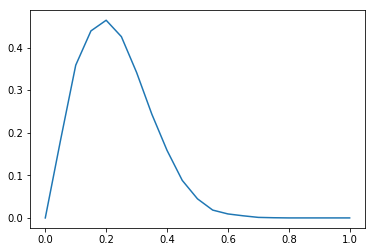

In [21]:
threshs = np.linspace(0, 1, 21)
plt.plot(threshs, fscores)
plt.xlabel = 'threshold'
plt.ylabel = 'fscore'
print(np.argmax(fscores) / 20, fscores[np.argmax(fscores)])

## without

In [36]:
threshs = np.linspace(0, 1, 21)
ret = []
for thresh in threshs:
    ret.append(evalfscore(datapath, [preds_1], [], num_slice=num_slice, thresh=thresh))
fscores = [o[0] for o in ret]

0.15 0.462845


[autoreload of v17 failed: Traceback (most recent call last):
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 368, in superreload
    module = reload(module)
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/twofyw/miniconda3/envs/fastai/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_fr

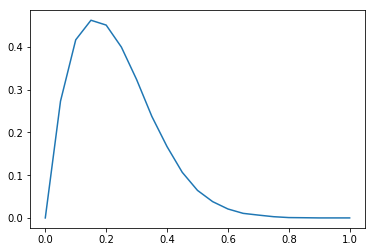

In [37]:
threshs = np.linspace(0, 1, 21)
plt.plot(threshs, fscores)
plt.xlabel = 'threshold'
plt.ylabel = 'fscore'
print(np.argmax(fscores) / 20, fscores[np.argmax(fscores)])

In [9]:
fscores, prs = evalfscore(datapath, [preds_1], [preds_rescale])

IndexError: index 225 is out of bounds for axis 0 with size 225

In [59]:
np.argmax(fscores) / 20, prs[np.argmax(fscores)]

(0.2, (0.475816, 0.453063))

In [53]:
p, r = zip(*prs[1:-5])

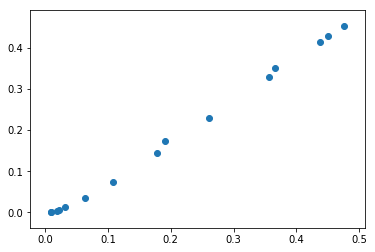

In [55]:
plt.scatter(p, r)

## evalfscore

In [4]:
model_name = 'deeplab'
data = None
is_eval, is_pred = True, False

In [27]:
learn, denorm, data = learner_on_dataset(datapath, bs, device_ids, num_workers, model_name='deeplab',
                                         debug=False, data=data, num_slice=num_slice, sz=sz,
                                        is_eval=is_eval, is_pred=is_pred, rescale=False)
(trn_x,trn_y), (val_x,val_y) = data
learn.load('deeplab-paris')

Data finished loading: data/train/AOI_3_Paris_Train


In [28]:
%%time
preds = learn.predict().squeeze()

CPU times: user 5h 8min 31s, sys: 27min 9s, total: 5h 35min 40s
Wall time: 8min 54s


In [10]:
%%time
evalfscore(datapath, preds)

CPU times: user 3min 19s, sys: 13.6 s, total: 3min 33s
Wall time: 2min 43s


(0.70298, 0.499119)

In [ ]:
scores = None

In [ ]:
scores, idx = plot_worse_preds(x, y, preds, learn, jaccard_coef, shift=600,
                          scores=scores, is_best=0, thresh=0.5)

In [ ]:
with open(FMT_VALTESTPOLY_PATH.format('AOI_3_Paris')) as f:
    polys = f.readlines()
len([o for o in polys if 'EMPTY' not in o])

Plot images

In [ ]:
fn_train = FMT_VALTEST_IMAGELIST_PATH.format(prefix='AOI_3_Paris')
df_train = pd.read_csv(fn_train)

In [ ]:
idx = 89
data_im = zip(preds_big[idx:idx + 9], x_big[idx:idx + 9], y_big[idx:idx + 9])
plot_ims(data_im, figsize=4)

## testproc

thresh = 0.35

### Eyeballing test result

In [19]:
%%time
learn.data.val_ds.rescale = False
with ThreadPoolExecutor(max_workers=1) as e:
    x, y = list(zip(*list(e.map(learn.data.val_dl.get_batch, [[o] for o in range(preds_1.shape[0])]))))
x, y, preds_1 = [np.squeeze(o) for o in (x, y, preds_1)]
print(x.shape)

(2304, 3, 256, 256)
CPU times: user 35min 19s, sys: 2min 23s, total: 37min 42s
Wall time: 1min 2s


In [26]:
preds_big.shape

(9, 650, 650)

In [37]:
preds_big = _internal_validate_predict_best_param(3, slice_pred_list=[preds_1], rescale_pred_list=[preds_rescale]
                                                 , debug=True, num_slice=289)
x_big = _internal_validate_predict_best_param(3, slice_pred_list=[denorm(x)[...,0]], debug=True, num_slice=289)
y_big = _internal_validate_predict_best_param(3, slice_pred_list=[y], debug=True, num_slice=289)

code/v17.py:324: RuntimeWarning: divide by zero encountered in true_divide
  pred_values = pred_values / pred_count
code/v17.py:324: RuntimeWarning: invalid value encountered in true_divide
  pred_values = pred_values / pred_count


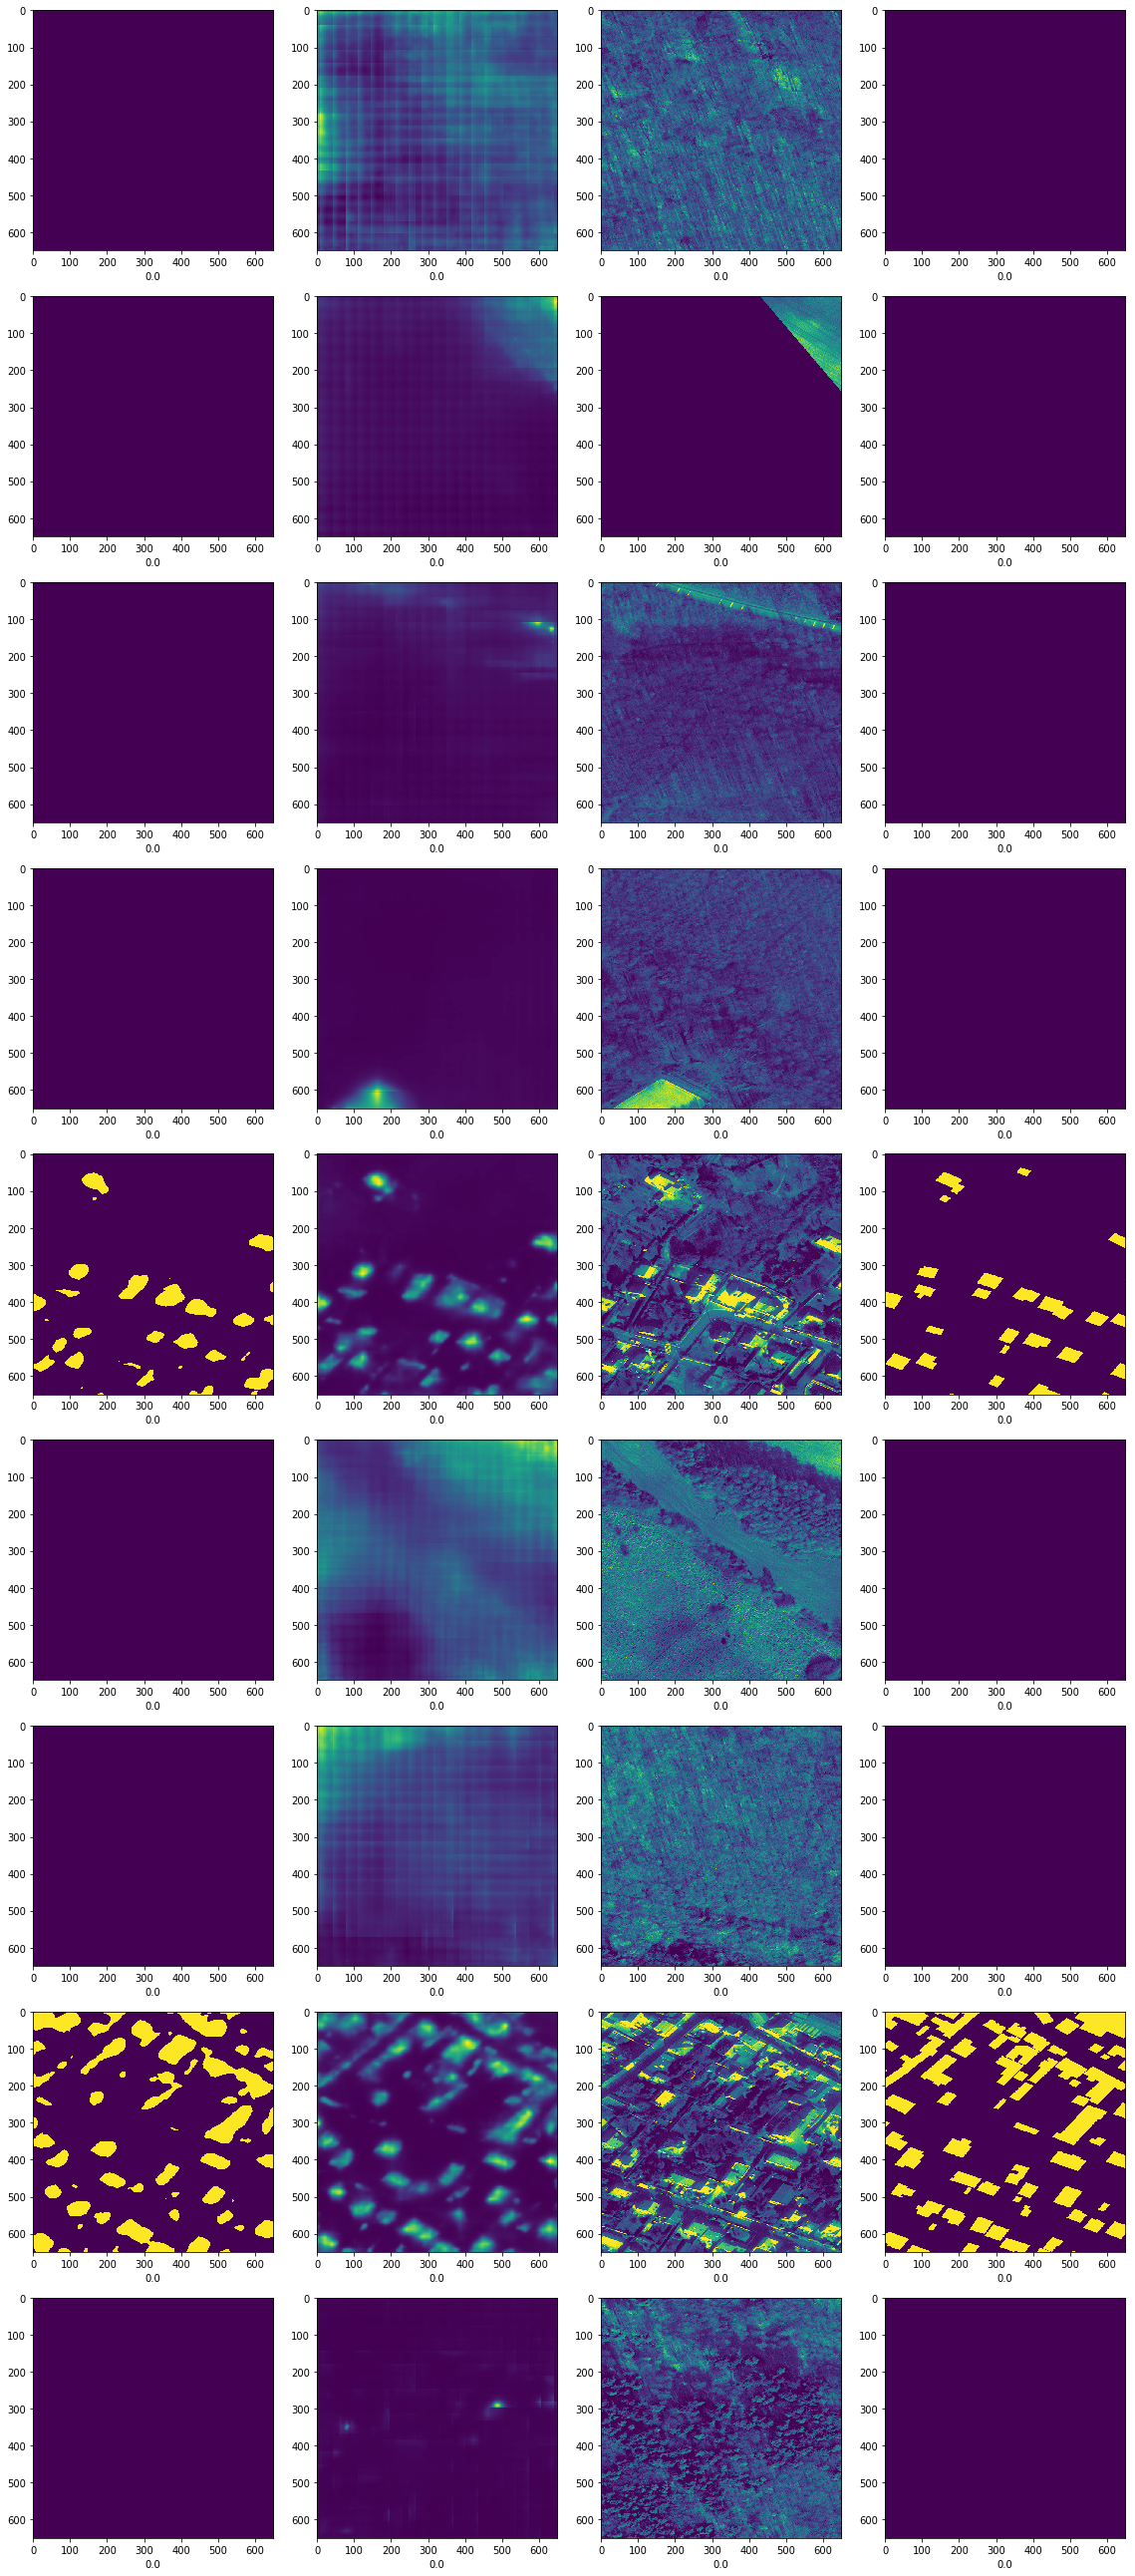

In [39]:
idx = 0
num_ims = 9
data_im = zip(preds_big[idx:idx + num_ims] > 0.2, preds_big[idx:idx + num_ims], 
              x_big[idx:idx + num_ims], y_big[idx:idx + num_ims])
plot_ims(data_im, figsize=4)

In [35]:
preds_big = _internal_validate_predict_best_param(3, slice_pred_list=[preds_1], rescale_pred_list=[]
                                                 , debug=True)
x_big = _internal_validate_predict_best_param(3, slice_pred_list=[denorm(x)[...,0]], debug=True)
y_big = _internal_validate_predict_best_param(3, slice_pred_list=[y], debug=True)

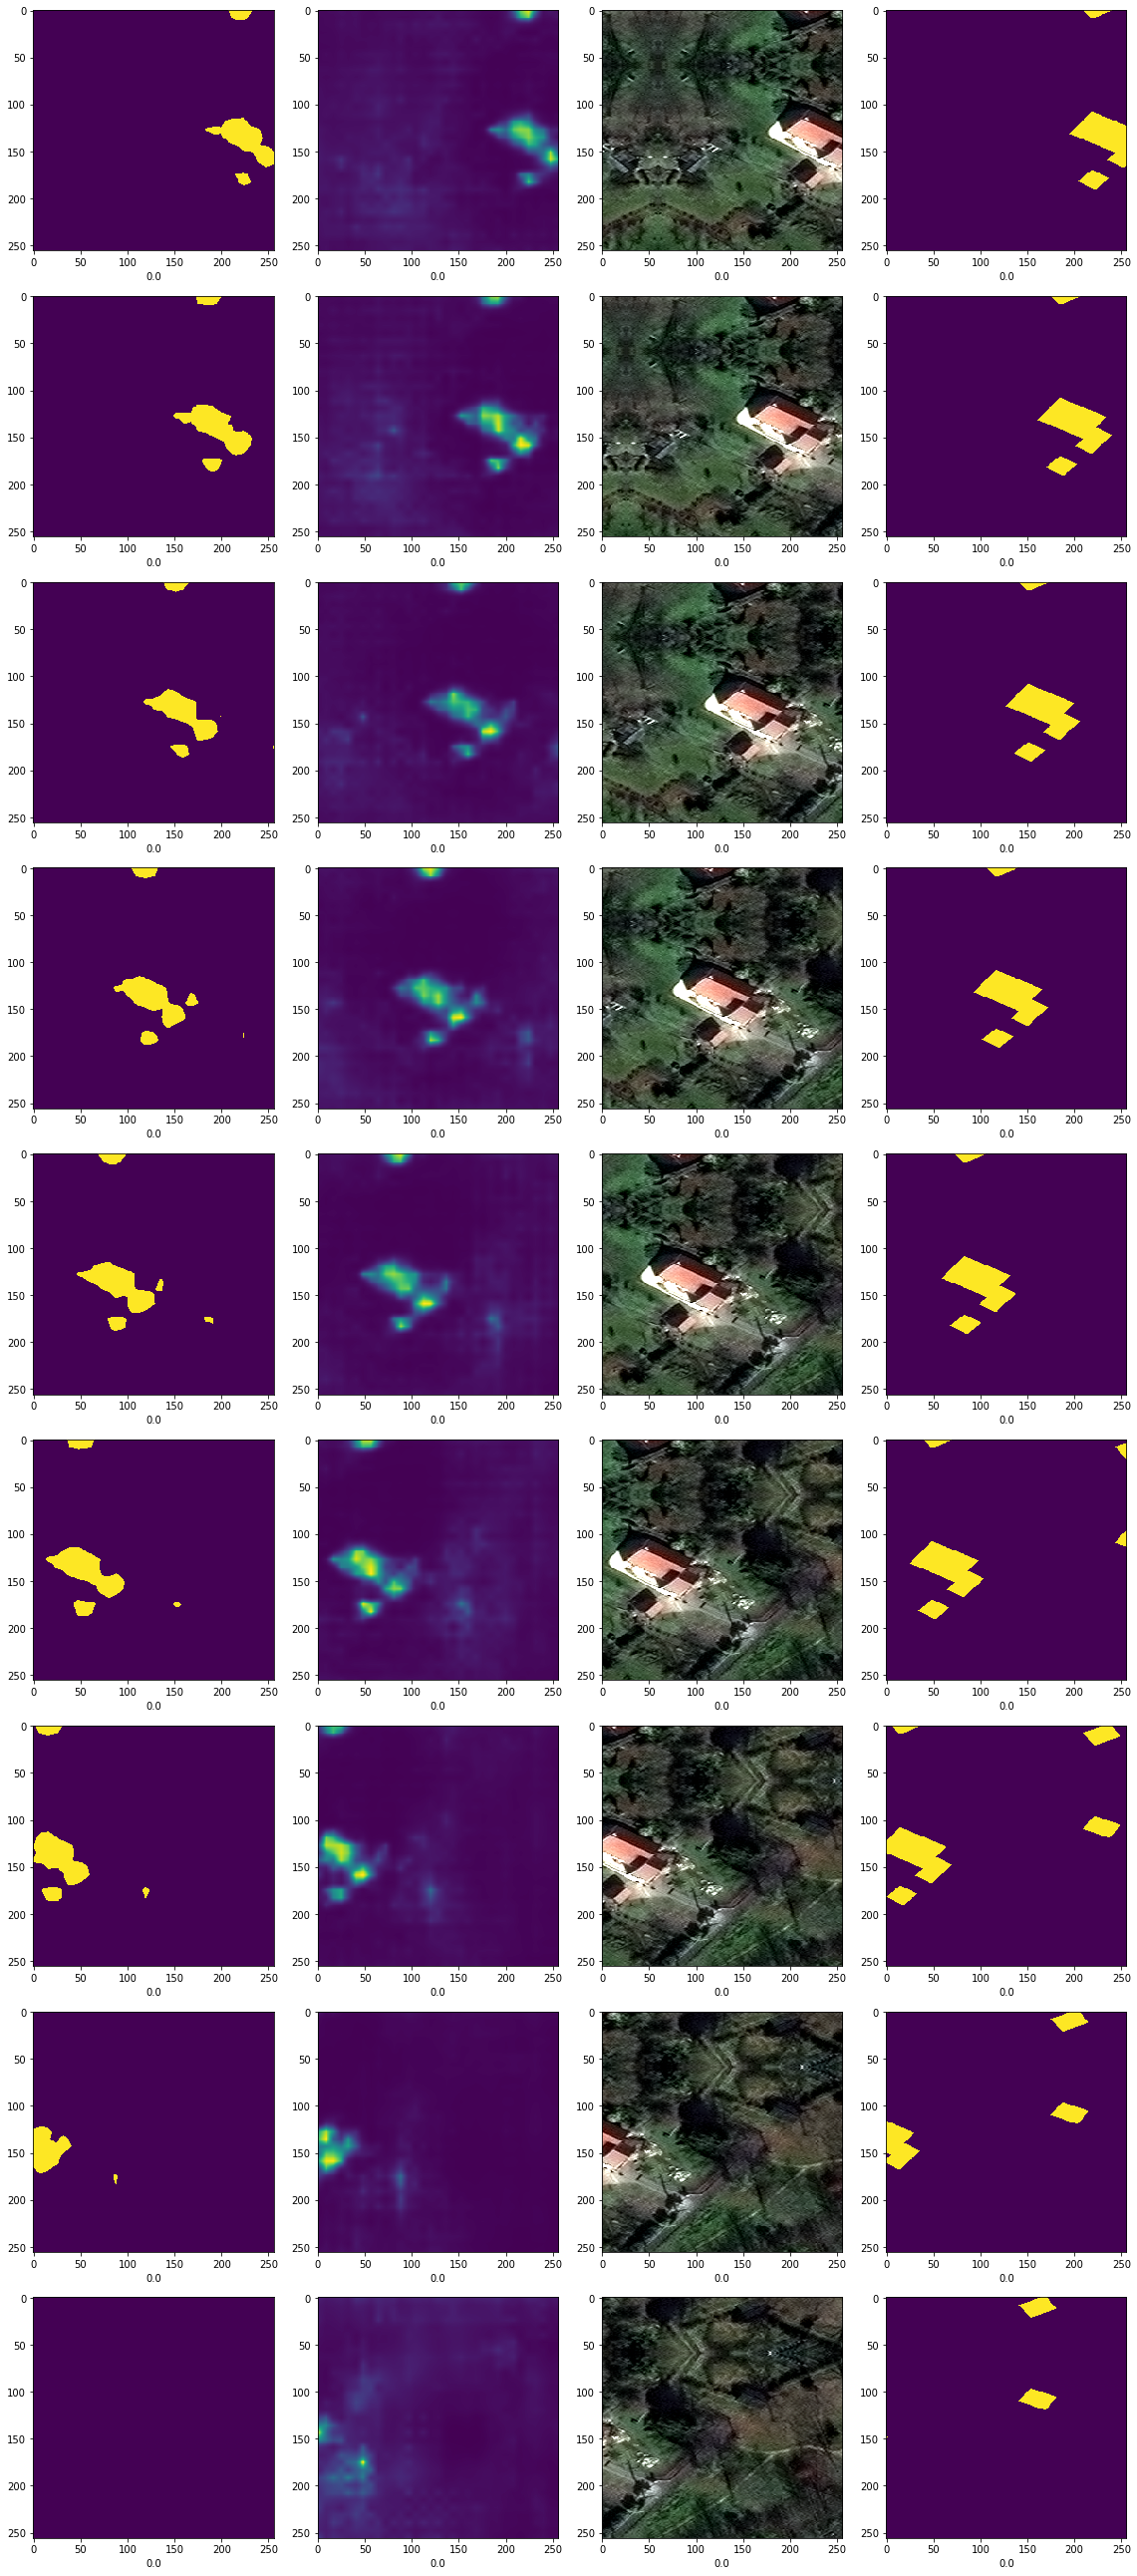

In [36]:
idx = 256 * 4
num_ims = 9
data_im = zip(preds_1[idx:idx + num_ims] > 0.2, preds_1[idx:idx + num_ims], 
              denorm(x)[idx:idx + num_ims], y[idx:idx + num_ims])
plot_ims(data_im, figsize=4)

In [67]:
preds_big = _internal_validate_predict_best_param(3, slice_pred_list=[preds_1], rescale_pred_list=[])
x_big = _internal_validate_predict_best_param(3, slice_pred_list=[denorm(x)[...,0]])
y_big = _internal_validate_predict_best_param(3, slice_pred_list=[y])

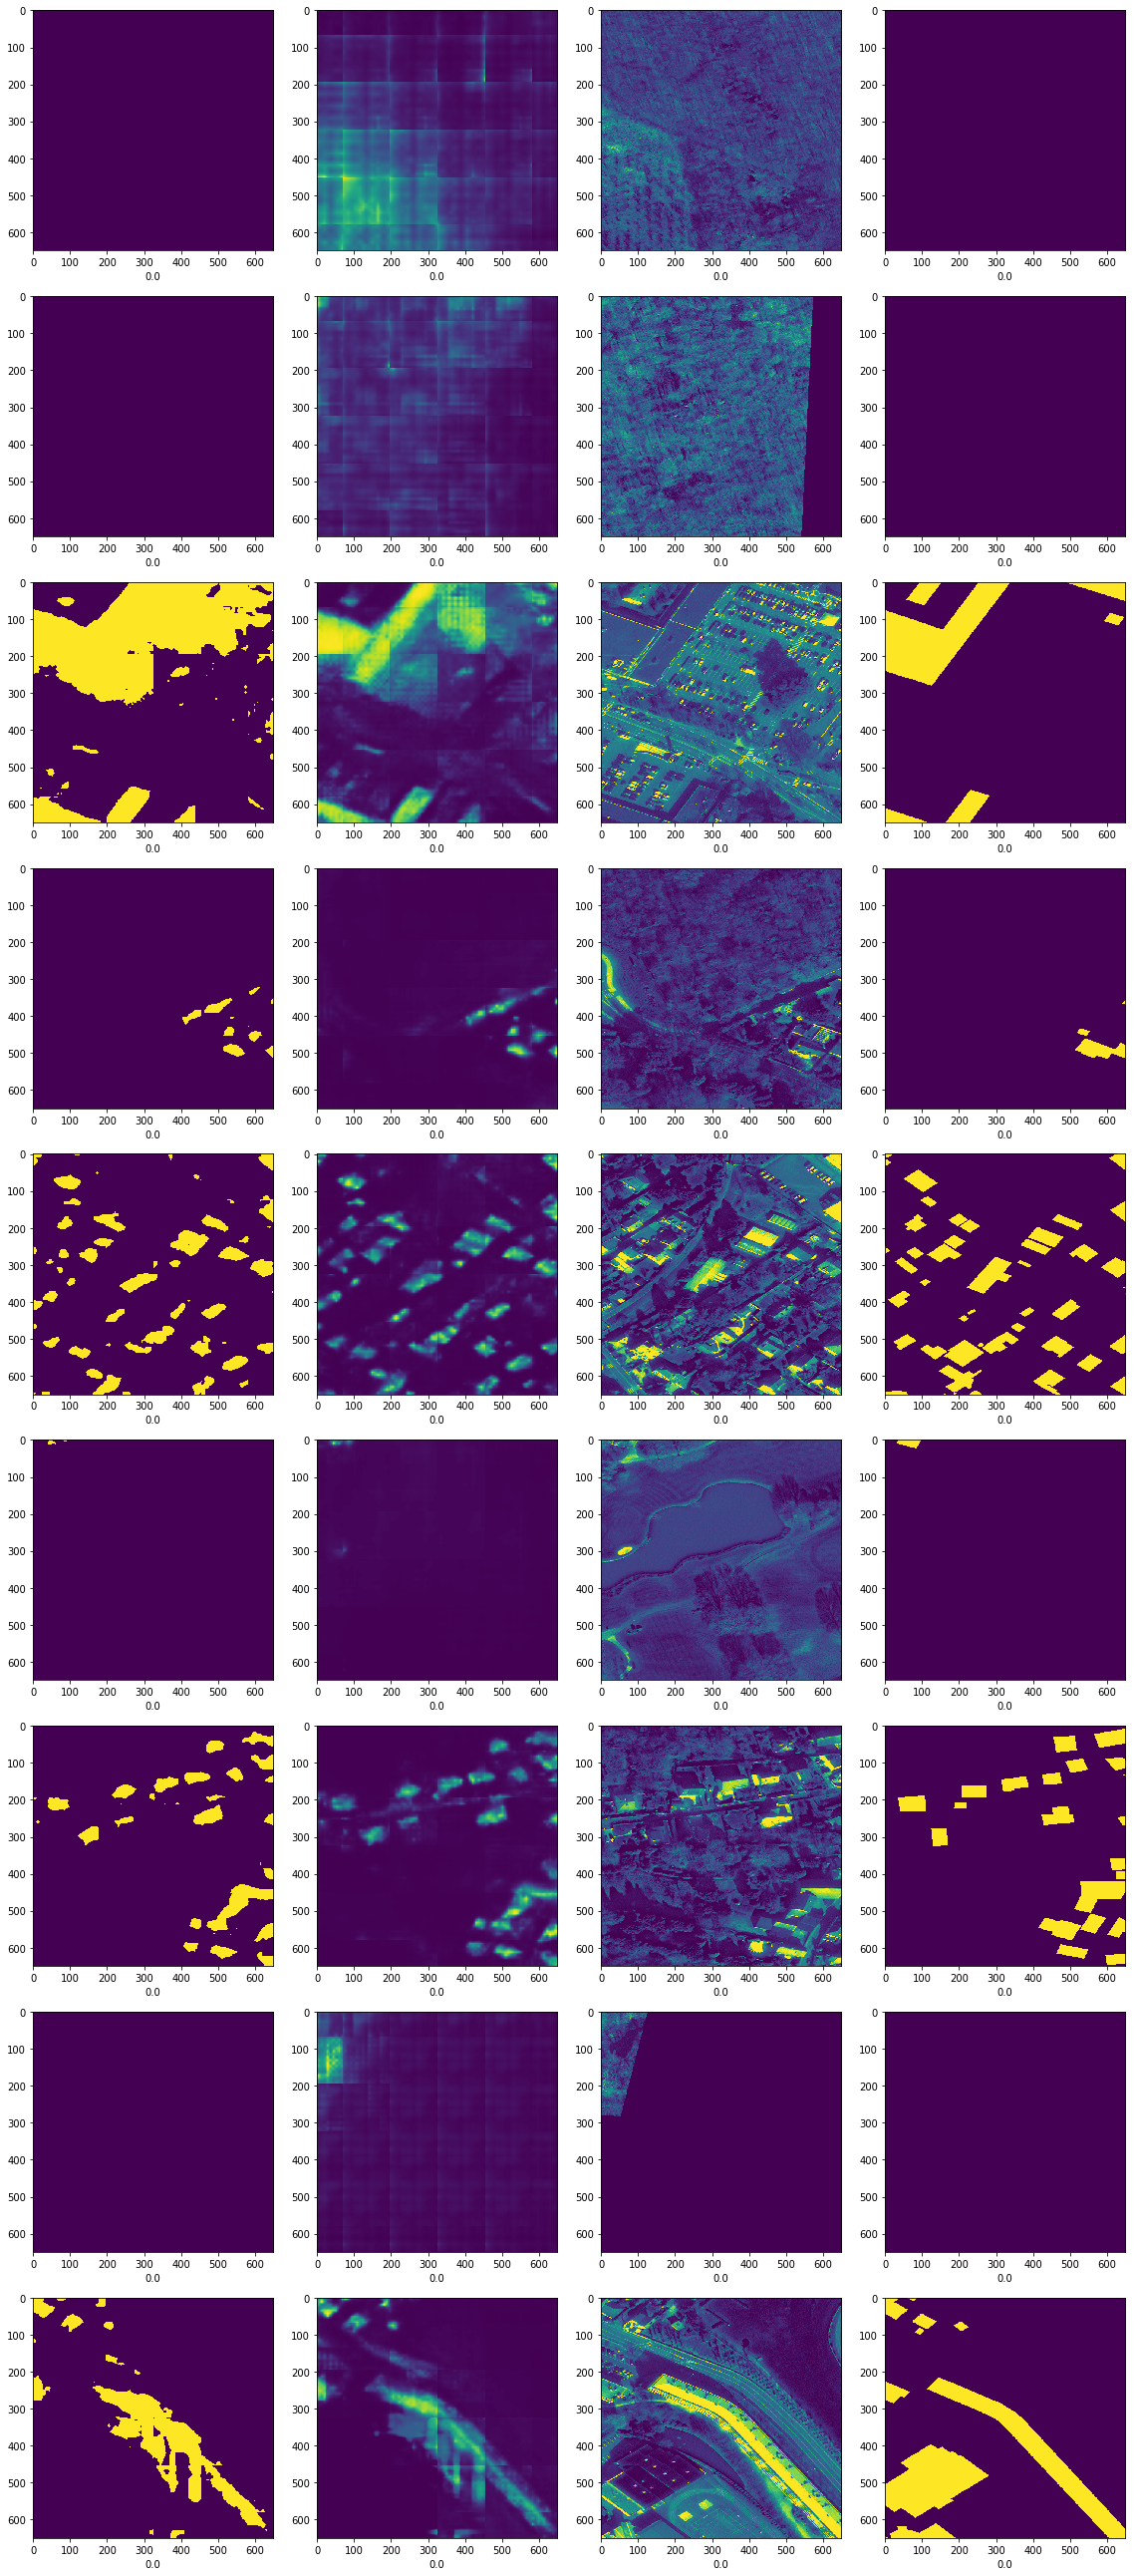

In [68]:
idx = 14
num_ims = 9
data_im = zip(preds_big[idx:idx + num_ims] > 0.2, preds_big[idx:idx + num_ims], 
              x_big[idx:idx + num_ims], y_big[idx:idx + num_ims])
plot_ims(data_im, figsize=4)

In [69]:
preds_big = _internal_validate_predict_best_param(3, slice_pred_list=[], rescale_pred_list=[preds_rescale])
x_big = _internal_validate_predict_best_param(3, slice_pred_list=[denorm(x)[...,0]])
y_big = _internal_validate_predict_best_param(3, slice_pred_list=[y])

code/v17.py:320: RuntimeWarning: divide by zero encountered in true_divide
  pred_values = pred_values / pred_count
code/v17.py:320: RuntimeWarning: invalid value encountered in true_divide
  pred_values = pred_values / pred_count


/home/twofyw/miniconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


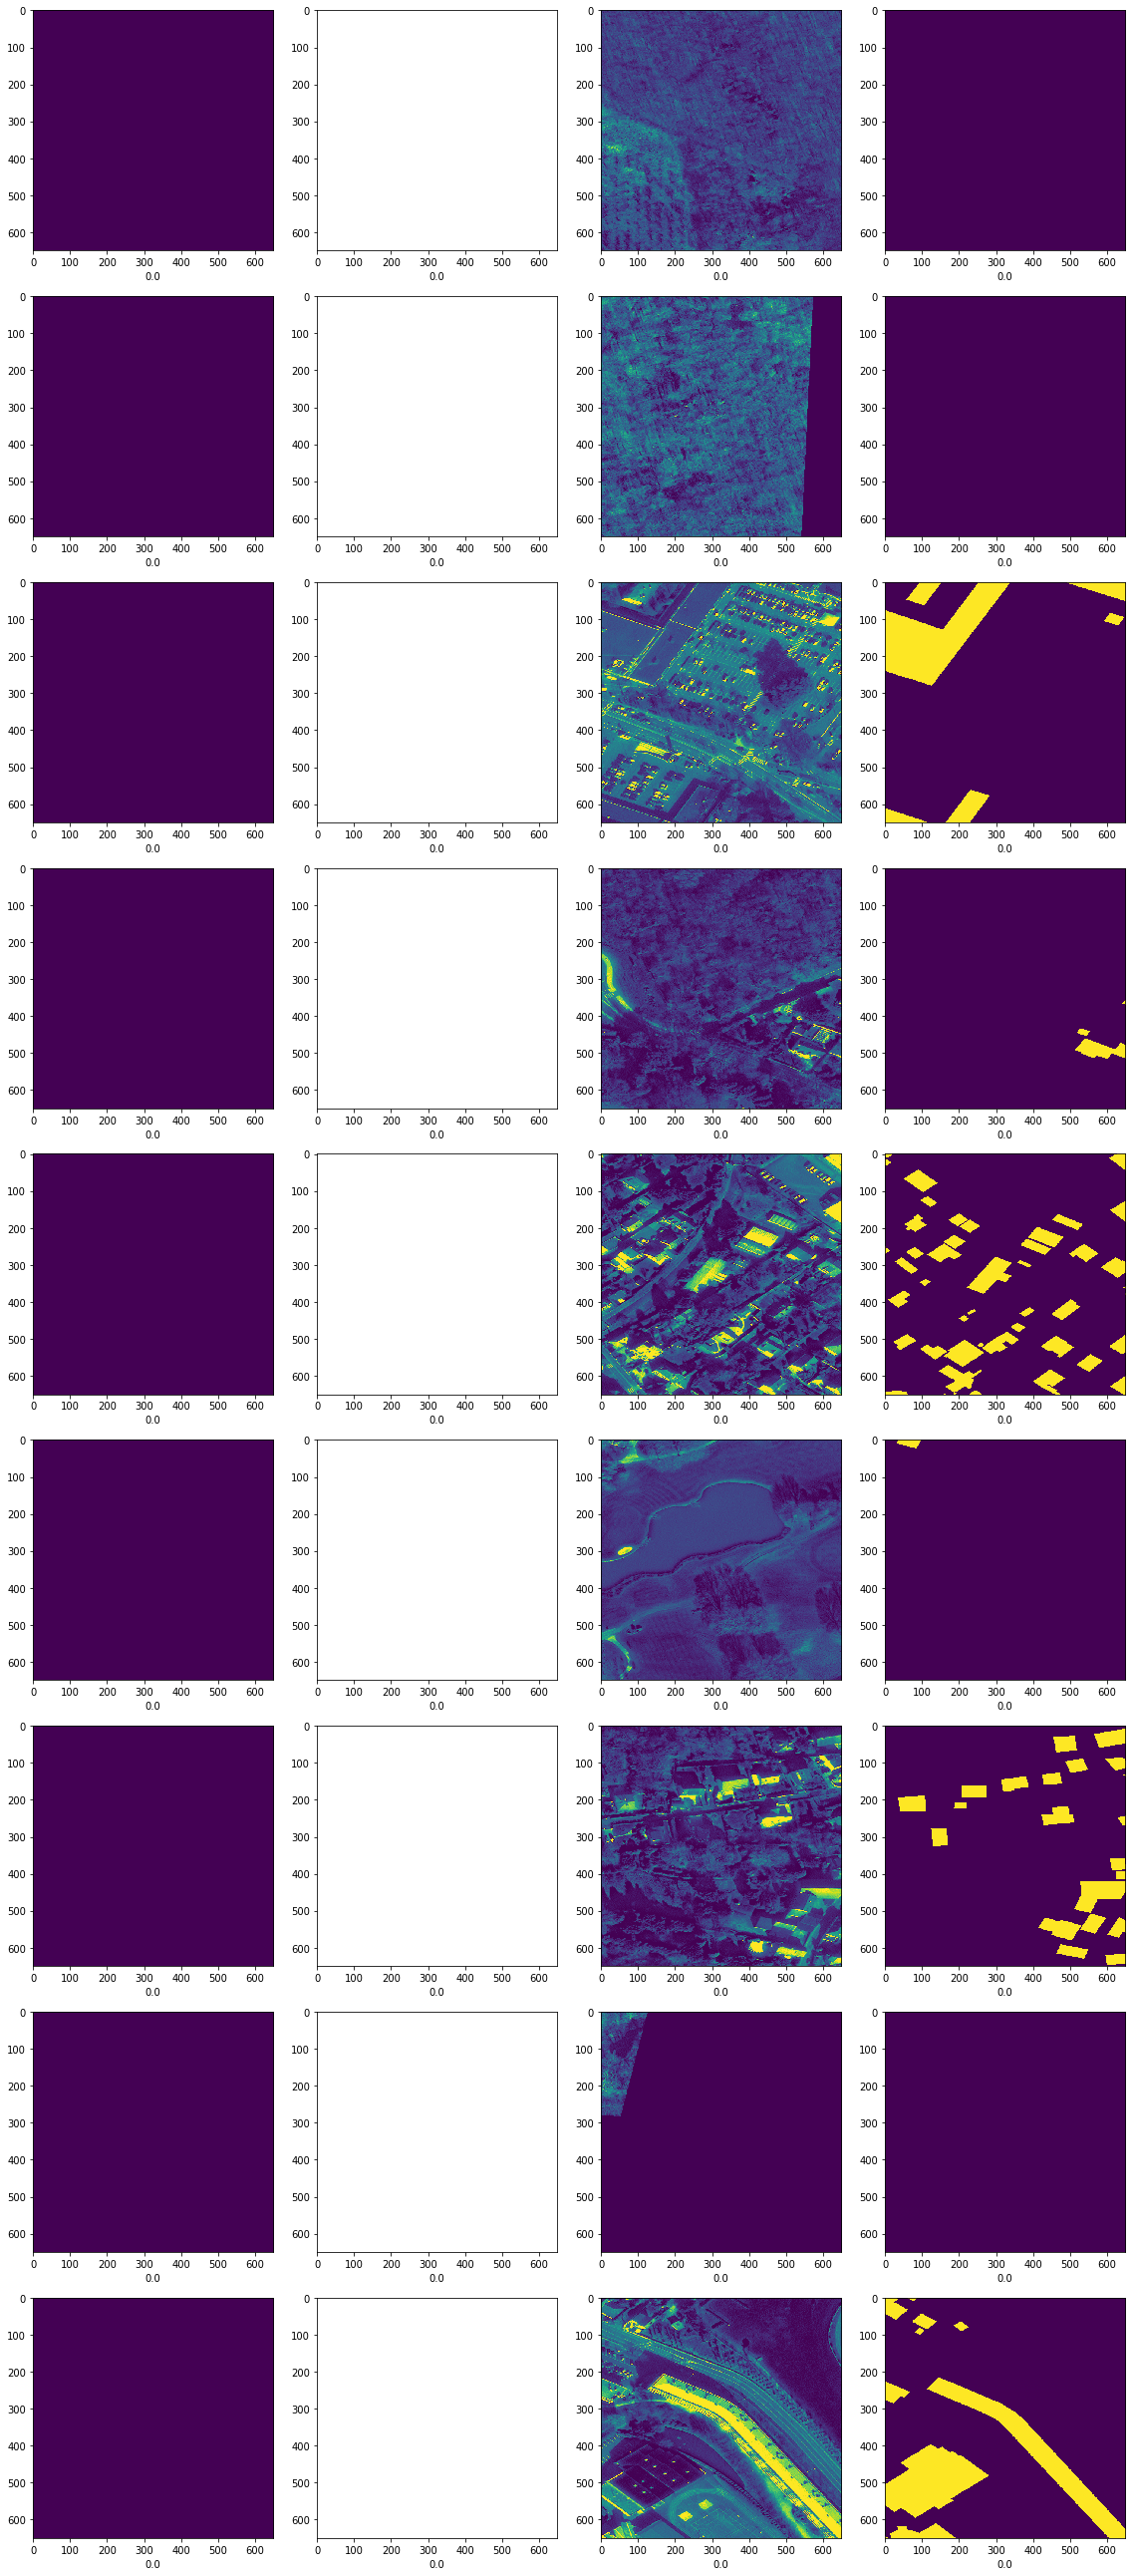

In [70]:
idx = 14
num_ims = 9
data_im = zip(preds_big[idx:idx + num_ims] > 0.2, preds_big[idx:idx + num_ims], 
              x_big[idx:idx + num_ims], y_big[idx:idx + num_ims])
plot_ims(data_im, figsize=4)

In [ ]:
scores = None

In [ ]:
scores = plot_worse_preds(x_big, y_big, preds_big, fscore, scores=scores, shift=100)

## Pixel level best threshold

In [46]:
fscore(preds_big, y_big, thresh=0.25)

0.7759074510092517

In [ ]:
# wrong pytorch implementation
%%time
threshs = np.linspace(0, 1, 3)
t_preds_big, t_y_big = T(preds_big).float(), T(y_big).float()
with ThreadPoolExecutor(max_workers=8) as e:
    gen = e.map(partial(pr, t_preds_big, t_y_big), threshs)

In [ ]:
%%time
threshs = np.linspace(0, 1, 20)
score = [pr_np(preds_big, y_big, thresh) for thresh in threshs]

In [ ]:
res = [(o[0][0], o[1][0]) for o in gen]

In [ ]:
plt.plot(*zip(*score))

In [ ]:
distance = [o[0] - o[1] for o in score]

In [ ]:
np.argmin(np.abs(distance)) / 20 

## Polygon best threshold

In [4]:
def evalfscore_thresh(thresh):
    return evalfscore(datapath, preds, thresh=thresh)

In [7]:
%%time
threshs = np.linspace(0, 1, 21)
polygon_pr = []
for thresh in threshs:
#     with ThreadPoolExecutor(max_workers=8) as e:
    s = evalfscore_thresh(thresh)
    print(s)
    polygon_pr.append(s)
# plt.plot(polygon_pr)

(0, 0)
(0.273282, 0.157779)
(0.510218, 0.319083)
(0.616744, 0.407448)
(0.676692, 0.456148)
(0.717342, 0.48766)
(0.741094, 0.513442)
(0.75319, 0.533275)
(0.744271, 0.5368)
(0.736288, 0.523579)
(0.70298, 0.499119)
(0.662707, 0.467166)
(0.600315, 0.419348)
(0.517955, 0.352799)
(0.405441, 0.269282)
(0.277308, 0.173424)
(0.15084, 0.085059)
(0.04962, 0.02446)
(0.013034, 0.003967)
(0.017921, 0.001102)
(0, 0)
CPU times: user 1h 2min 47s, sys: 4min 42s, total: 1h 7min 30s
Wall time: 37min 45s


In [14]:
epsilon = 1e-12
fscore = [2 * o[0] * o[1] / (o[0] + o[1] + epsilon) for o in polygon_pr]

0.35 0.6244357945994453


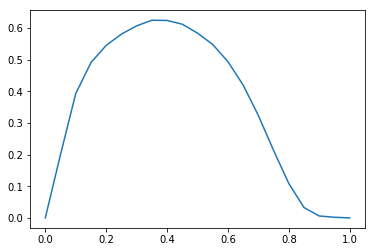

In [20]:
plt.plot(threshs, fscore)
plt.xlabel = 'threshold'
plt.ylabel = 'fscore'
print(np.argmax(fscore) / 20, fscore[np.argmax(fscore)])

In [67]:
# %%time
# threshs = np.linspace(0, 1, 20)
# polygon_pr = []
# for thresh in threshs:
#     polygon_pr.append(evalfscore(datapath, preds, thresh))
# plt.plot(polygon_pr)

0.0 (0, 0)
0.05263157894736842 (0.281055, 0.169017)


KeyboardInterrupt: 

CPU times: user 1h 9min 29s, sys: 5min 39s, total: 1h 15min 9s
Wall time: 44min 24s


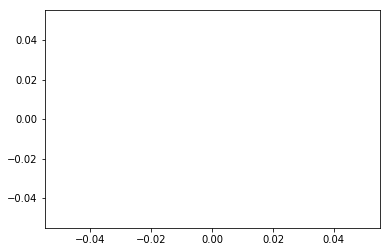

In [72]:
# %%time
# threshs = np.linspace(0, 1, 21)
# for thresh in threshs:
#     with ThreadPoolExecutor(max_workers=8) as e:
#         polygon_pr = list(e.map(evalfscore_thresh(thresh)))
# plt.plot(polygon_pr)

In [74]:
polygon_pr

[]

## Guided Filter

In [24]:
sns.set(style="white")
srcs = (preds_big * 255).astype('uint8')
guides = (x_big * 255).astype('uint8')
gts = (y_big * 255).astype('uint8')

In [25]:
idx = 16
plt.imshow(cv2.ximgproc.guidedFilter(guides[16], srcs[16], radius=radius[3], eps=eps[3]))

NameError: name 'radius' is not defined

In [ ]:
%%time
rows, cols = 5, 10
radius = np.arange(1, 6, 1).astype('uint8')
eps = np.linspace(10, 50, 40 / cols + 1).astype('uint8')
res = np.empty([rows, cols] + list(srcs.shape))
for row, r in enumerate(radius):
    for col, e in enumerate(eps):    
#         for i, src in enumerate(srcs):
        with ThreadPoolExecutor(max_workers=8) as e:
            res_batch = list(e.map((partial(cv2.ximgproc.guidedFilter, radius=r, eps=e), guides, srcs)))
            for i, res_im in enumerate(res_batch):
                res[row, col, i] = res_im

In [ ]:
%%time
score_mat = np.empty([rows, cols])
for row, r in enumerate(radius):
    with ThreadPoolExecutor(max_workers=8) as e:
        res_cols = list(e.map(fscore, res[row] > int(255), np.broadcast_to(gts, [cols] + list(gts.shape))))
        for i, res_col in enumerate(res_cols):
            score_mat[row, i] = res_col

In [ ]:
sns.set(style="white")
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(score_mat, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": 1})
# ax.xaxis.set_ticks(eps)
print(score_mat.argmax())